# About

This notebook compares the behavior of Chainlink and Empiric on starknet during the USDC depeg event of March 2023.

Both Chainlink and Empiric are live on Starknet Testnet.

In [140]:
import pandas as pd
import matplotlib.pyplot as plt

In [141]:
time_window = (1678407048, 1678579200)  # 1st to 12th of March 2023


In [151]:
empiric = pd.read_csv("../../empiric-events.csv")
empiric = empiric.drop(columns=["Unnamed: 0", "pair_id", "volume", "price"])
empiric["datetime"] = pd.to_datetime(empiric["datetime"])
empiric = empiric[empiric["key"] == "DAI/USD"]
empiric.loc[:, ["transaction_hash",]] = empiric["transaction_hash"].apply(lambda x: hex(int(x)))
empiric = empiric[(empiric["timestamp"] > time_window[0]) & (empiric["timestamp"] <= time_window[1])].reset_index(drop=True)
# Take the median values for each 1min interval
empiric = empiric.groupby(pd.Grouper(key="datetime", freq="3min")).median().reset_index()
empiric.head()

,datetime,timestamp,value
0,2023-03-10 00:09:00,1.678407e+09,0.998090
1,2023-03-10 00:12:00,1.678407e+09,1.004325
2,2023-03-10 00:15:00,1.678407e+09,0.999850
3,2023-03-10 00:18:00,1.678407e+09,0.999430
4,2023-03-10 00:21:00,NaN,NaN


In [152]:
len(empiric)

948

In [145]:
chainlink = pd.read_csv("../../chainlink-data/dai-chainlink-events.csv")
chainlink["datetime"] = pd.to_datetime(chainlink["observation_timestamp"], unit="s")
chainlink = chainlink.drop(
    columns=["round_id", "reimbursement", "transmitter", "gas_price", "epoch_and_round", "observations_len", "juels_per_fee_coin", "observers", "config_digest"])
chainlink = chainlink.rename(columns={"answer": "value"})
chainlink = chainlink[(chainlink["observation_timestamp"] > time_window[0]) & (
    chainlink["observation_timestamp"] <= time_window[1])].reset_index(drop=True)
chainlink["value"] = chainlink["value"] / (10**8)
chainlink.head()

,Unnamed: 0,value,observation_timestamp,transaction_hash,value,datetime
0,59652,0.999414,1.678407e+09,2117898287632783433358923925337043890606620099...,9.994141e-09,2023-03-10 00:15:15
1,59653,0.999508,1.678407e+09,1718533434622127760241752342198081422309674447...,9.995077e-09,2023-03-10 00:15:54
2,59654,0.999273,1.678407e+09,3374719906991716315173164846539331220619736866...,9.992733e-09,2023-03-10 00:18:04
3,59655,0.999441,1.678408e+09,3374719906991716315173164846539331220619736866...,9.994411e-09,2023-03-10 00:18:25
4,59656,0.999478,1.678408e+09,3374719906991716315173164846539331220619736866...,9.994776e-09,2023-03-10 00:18:47


In [146]:
print(len(chainlink))
chainlink.isna().sum()

1570


Unnamed: 0                0
value                    17
observation_timestamp     0
transaction_hash          0
value                    17
datetime                  0
dtype: int64

In [147]:
chainlink = chainlink.loc[:, ~chainlink.columns.duplicated()]
chainlink.head()

,Unnamed: 0,value,observation_timestamp,transaction_hash,datetime
0,59652,0.999414,1.678407e+09,2117898287632783433358923925337043890606620099...,2023-03-10 00:15:15
1,59653,0.999508,1.678407e+09,1718533434622127760241752342198081422309674447...,2023-03-10 00:15:54
2,59654,0.999273,1.678407e+09,3374719906991716315173164846539331220619736866...,2023-03-10 00:18:04
3,59655,0.999441,1.678408e+09,3374719906991716315173164846539331220619736866...,2023-03-10 00:18:25
4,59656,0.999478,1.678408e+09,3374719906991716315173164846539331220619736866...,2023-03-10 00:18:47


In [153]:
datasets = [(empiric, "Empiric"), (chainlink, "Chainlink")]

In [154]:
for dataset, label in datasets:
    dataset = dataset.sort_values("datetime")
    dataset["previous_datetime"] = dataset.shift(1)["datetime"]
    dataset["time_diff"] = dataset["datetime"] - dataset["previous_datetime"]
    dataset["seconds_diff"] = dataset["time_diff"].apply(lambda x: x.seconds)
    print(label)
    print(dataset["seconds_diff"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
    print("Outages")
    print(dataset[dataset["seconds_diff"] > 1200])

Empiric
count    947.0
mean     180.0
std        0.0
min      180.0
25%      180.0
50%      180.0
75%      180.0
90%      180.0
95%      180.0
99%      180.0
max      180.0
Name: seconds_diff, dtype: float64
Outages
Empty DataFrame
Columns: [datetime, timestamp, value, previous_datetime, time_diff, seconds_diff]
Index: []
Chainlink
count    1569.000000
mean      109.374761
std       139.177026
min         2.000000
25%        24.000000
50%        63.000000
75%       133.000000
90%       262.400000
95%       384.600000
99%       654.000000
max      1491.000000
Name: seconds_diff, dtype: float64
Outages
      Unnamed: 0     value  observation_timestamp  \
497        60189  0.999101           1.678464e+09   
1217       60974  0.929954           1.678542e+09   

                                       transaction_hash            datetime  \
497   8306711579271796486240341397723005546853280641... 2023-03-10 15:52:49   
1217  8928911923552336828237042981437137214947530110... 2023-03-11 13:42:3

             datetime     timestamp     value
0 2023-03-10 00:09:00  1.678407e+09  0.998090
1 2023-03-10 00:12:00  1.678407e+09  1.004325
2 2023-03-10 00:15:00  1.678407e+09  0.999850
3 2023-03-10 00:18:00  1.678407e+09  0.999430
4 2023-03-10 00:21:00           NaN       NaN
   Unnamed: 0     value  observation_timestamp  \
0       59652  0.999414           1.678407e+09   
1       59653  0.999508           1.678407e+09   
2       59654  0.999273           1.678407e+09   
3       59655  0.999441           1.678408e+09   
4       59656  0.999478           1.678408e+09   

                                    transaction_hash            datetime  
0  2117898287632783433358923925337043890606620099... 2023-03-10 00:15:15  
1  1718533434622127760241752342198081422309674447... 2023-03-10 00:15:54  
2  3374719906991716315173164846539331220619736866... 2023-03-10 00:18:04  
3  3374719906991716315173164846539331220619736866... 2023-03-10 00:18:25  
4  337471990699171631517316484653933122061973686

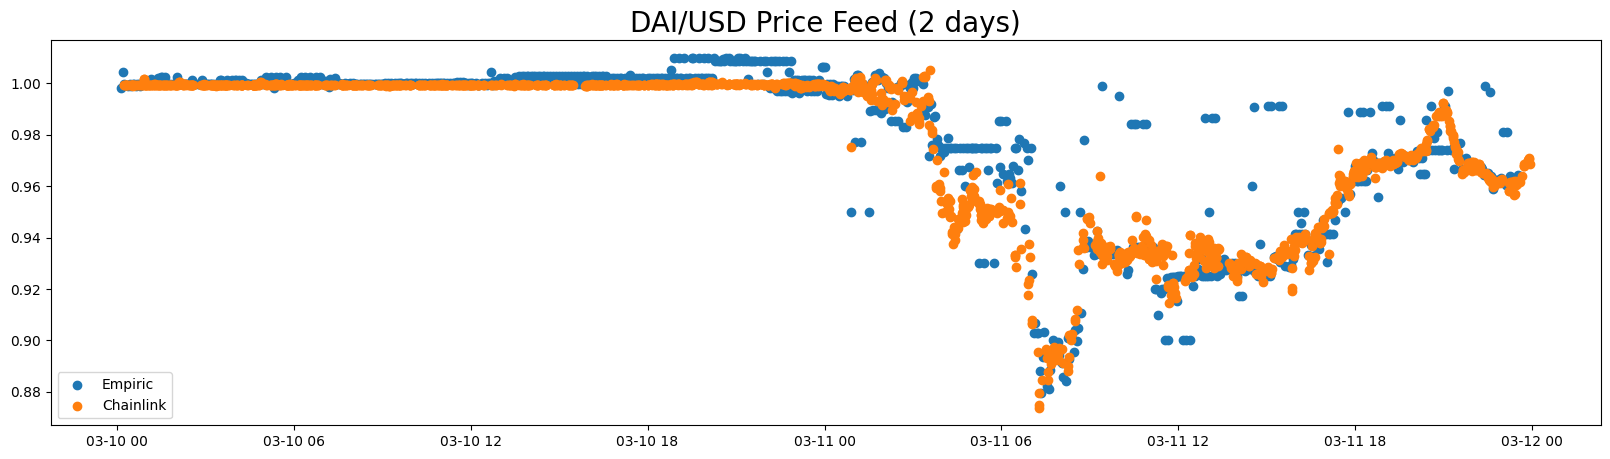

In [155]:
plt.figure(figsize=(20, 5))
for dataset, label in datasets:
    print(dataset.head())
    plt.scatter(dataset["datetime"], dataset["value"], label=label)

plt.title("DAI/USD Price Feed (2 days)", fontsize=20)
plt.legend()
plt.show()

## Precision

In [ ]:
# Need to aggregate - take the median of all the values currently available

from statistics import median

publisher_values = {}
empiric["current_median"] = 0
for i, row in empiric.iterrows():
    publisher_values[row["source"]] = row["value"]
    empiric.loc[i, "current_median"] = median(publisher_values.values())

In [ ]:
# Then find the Chainlink datapoint for benchmarking precision
chainlink = chainlink.sort_values("observation_timestamp").reset_index(drop=True)
empiric["last_chainlink_timestamp"] = 0
last_chainlink_timestamp_index = 0
last_chainlink_timestamp = chainlink.loc[last_chainlink_timestamp_index,
                                         "observation_timestamp"]
for i, row in empiric.iterrows():
    if last_chainlink_timestamp > time_window[1] or last_chainlink_timestamp_index+1 >= len(chainlink):
        break # Reached end of time window
    if row["timestamp"] > chainlink.loc[last_chainlink_timestamp_index+1, "observation_timestamp"]:  # Move on to next timestamp
        last_chainlink_timestamp_index += 1
        last_chainlink_timestamp = chainlink.loc[last_chainlink_timestamp_index,
                                                 "observation_timestamp"]

    empiric.loc[i, "last_chainlink_timestamp"] = last_chainlink_timestamp

In [ ]:
combined_empiric = pd.merge(chainlink, empiric, left_on='timestamp', right_on="last_chainlink_timestamp", how='inner', suffixes=["_chainlink", "_empiric"])
combined_empiric["difference"] = combined_empiric["current_median"] - combined_empiric["value_chainlink"]
combined_empiric["percentage_difference"] = combined_empiric["difference"] / combined_empiric["value_chainlink"]
combined_empiric = combined_empiric[combined_empiric["timestamp_chainlink"] < combined_empiric["timestamp_empiric"]]
combined_empiric

KeyError: 'timestamp'

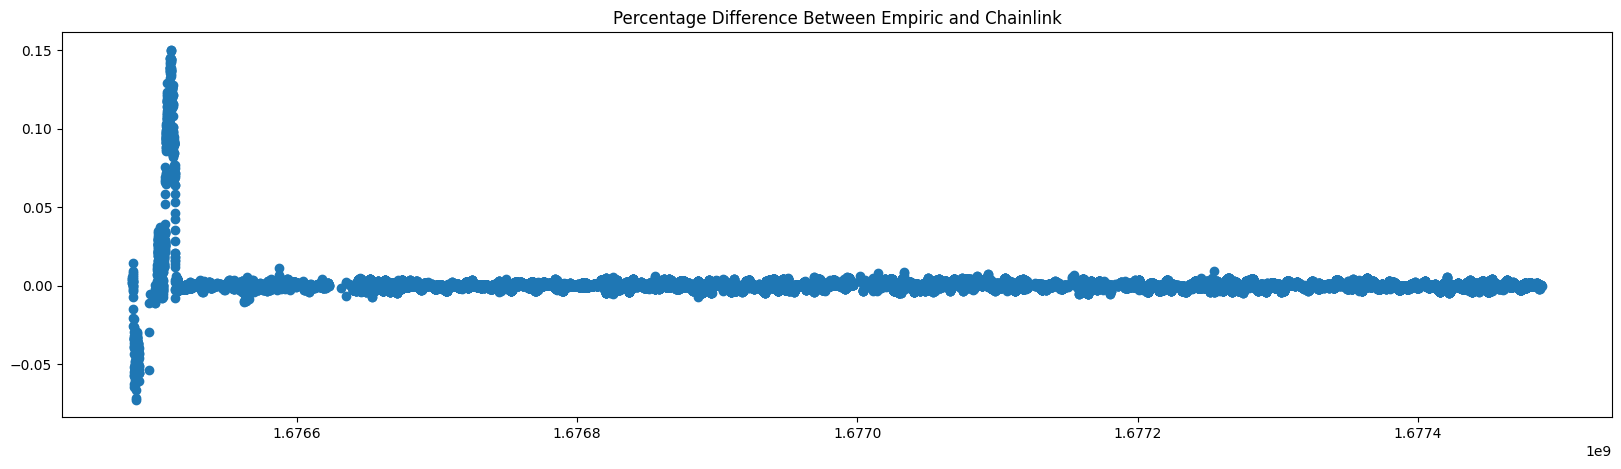

In [ ]:
plt.figure(figsize=(20, 5))
plt.scatter(combined_empiric["timestamp_empiric"], combined_empiric["percentage_difference"])
plt.title("Percentage Difference Between Empiric and Chainlink")
plt.show()

In [ ]:
max(combined_empiric["percentage_difference"])

0.15029589823821513

In [ ]:
# Then find the Chainlink datapoint for benchmarking precision
chainlink = chainlink.sort_values("timestamp").reset_index(drop=True)
stork["last_chainlink_timestamp"] = 0
last_chainlink_timestamp_index = 0
last_chainlink_timestamp = chainlink.loc[last_chainlink_timestamp_index, "timestamp"]
for i, row in stork.iterrows():
    if last_chainlink_timestamp > time_window[1] or last_chainlink_timestamp_index+1 >= len(chainlink):
        break # Reached end of time window
    if row["timestamp"] > chainlink.loc[last_chainlink_timestamp_index+1, "timestamp"]: # Move on to next timestamp
        last_chainlink_timestamp_index += 1
        last_chainlink_timestamp = chainlink.loc[last_chainlink_timestamp_index, "timestamp"]

    stork.loc[i, "last_chainlink_timestamp"] = last_chainlink_timestamp

NameError: name 'stork' is not defined

In [ ]:
combined_stork = pd.merge(chainlink, stork, left_on='timestamp', right_on="last_chainlink_timestamp", how='inner', suffixes=["_chainlink", "_stork"])
combined_stork["difference"] = combined_stork["value_stork"] - combined_stork["value_chainlink"]
combined_stork["percentage_difference"] = combined_stork["difference"] / combined_stork["value_chainlink"]
combined_stork = combined_stork[combined_stork["timestamp_chainlink"] < combined_stork["timestamp_stork"]]
combined_stork

,value_chainlink,timestamp_chainlink,datetime_chainlink,asset,value_stork,timestamp_stork,publisher,type,datetime_stork,last_chainlink_timestamp,difference,percentage_difference
3,1988.290000,1660362370,2022-08-13 03:46:10,1.951444e+16,1982.577160,1.660363e+09,25789180169021501187677569358,1.953064e+09,2022-08-13 03:51:10,1660362370,-5.712840,-0.002873
4,1988.290000,1660362370,2022-08-13 03:46:10,1.951444e+16,1985.043269,1.660363e+09,25789180169021501187677569358,1.953064e+09,2022-08-13 03:57:10,1660362370,-3.246731,-0.001633
5,1991.778051,1660363136,2022-08-13 03:58:56,1.951444e+16,1992.241509,1.660364e+09,25789180169021501187677569358,1.953064e+09,2022-08-13 04:09:10,1660363136,0.463458,0.000233
6,1991.778051,1660363136,2022-08-13 03:58:56,1.951444e+16,1991.161022,1.660364e+09,25789180169021501187677569358,1.953064e+09,2022-08-13 04:12:10,1660363136,-0.617028,-0.000310
7,2003.353785,1660364702,2022-08-13 04:25:02,1.951444e+16,1996.648492,1.660365e+09,25789180169021501187677569358,1.953064e+09,2022-08-13 04:33:10,1660364702,-6.705293,-0.003347
...,...,...,...,...,...,...,...,...,...,...,...,...
272,1979.580000,1660485315,2022-08-14 13:55:15,1.951444e+16,1981.590398,1.660486e+09,25789180169021501187677569358,1.953064e+09,2022-08-14 14:06:10,1660485315,2.010398,0.001016
273,1979.580000,1660485315,2022-08-14 13:55:15,1.951444e+16,1982.350588,1.660487e+09,25789180169021501187677569358,1.953064e+09,2022-08-14 14:15:09,1660485315,2.770588,0.001400
274,1979.580000,1660485315,2022-08-14 13:55:15,1.951444e+16,1984.556139,1.660487e+09,25789180169021501187677569358,1.953064e+09,2022-08-14 14:24:10,1660485315,4.976139,0.002514
275,1979.580000,1660485315,2022-08-14 13:55:15,1.951444e+16,1981.470368,1.660489e+09,25789180169021501187677569358,1.953064e+09,2022-08-14 14:54:09,1660485315,1.890368,0.000955


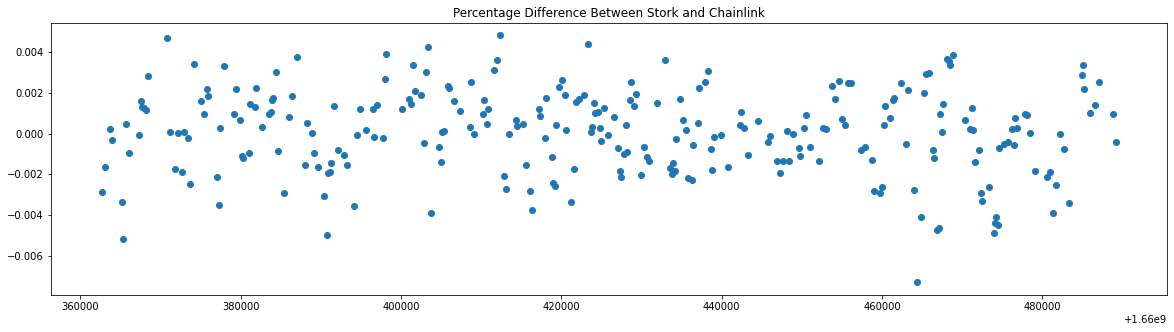

In [ ]:
plt.figure(figsize=(20, 5))
plt.scatter(combined_stork["timestamp_stork"], combined_stork["percentage_difference"])
plt.title("Percentage Difference Between Stork and Chainlink")
plt.show()

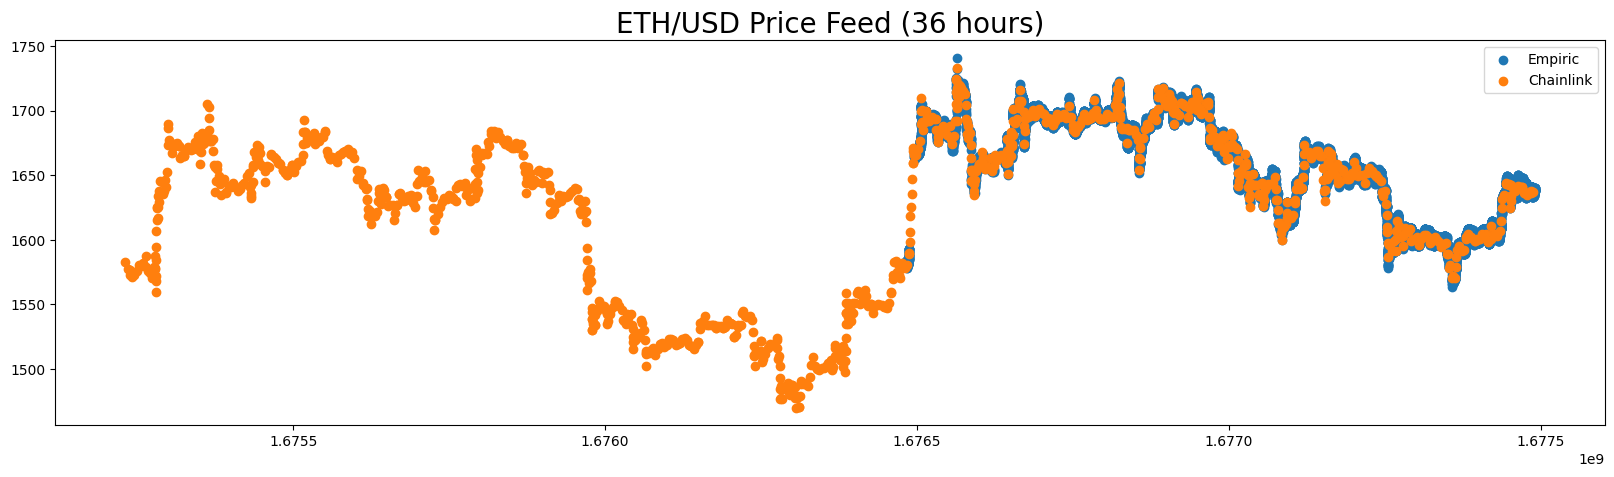

In [ ]:
plt.figure(figsize=(20, 5))
for dataset, label in datasets:
    plt.scatter(dataset["timestamp"], dataset["value"], label=label)

plt.title("ETH/USD Price Feed (36 hours)", fontsize=20)
plt.legend()
plt.show()

In [ ]:
max(combined_stork["percentage_difference"])

0.004830634689614337